![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Загрузим и посмотрим на весь датасет

In [6]:
display(data.info())
display(data.describe())
display(data.describe(include = ['object']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


None

,Ranking,Number of Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


,Restaurant_id,City,Cuisine Style,Price Range,Reviews,URL_TA,ID_TA
count,50000,50000,38410,32639,49998,50000,50000
unique,13094,31,10731,3,41857,49963,49963
top,id_227,London,['Italian'],$$ - $$$,"[[], []]",/Restaurant_Review-g187514-d1235635-Reviews-Re...,d4600226
freq,19,7193,1332,23041,8112,2,2


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

In [7]:
# приведем наименование некоторых столбцов к более удобному виду, уберем пробелы
data = data.rename(columns={'Cuisine Style': 'Cuisine_Style','Price Range': 'Price_Range', 'Number of Reviews': 
                            'Number_of_Reviews'})

# Рассмотрим все 10 столбцов по отдельности, выполним очистку и преобразование данных, выполним EDA, создадим новые признаки для модели

### Restaurant_id — идентификационный номер ресторана / сети ресторанов

In [8]:
data.loc[:, ['Restaurant_id']].info()
display(pd.DataFrame(data.Restaurant_id.value_counts()))
data.Restaurant_id.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Restaurant_id    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


,Restaurant_id
id_227,19
id_436,19
id_871,19
id_633,19
id_534,18
...,...
id_13657,1
id_15625,1
id_8945,1
id_9525,1


count      50000
unique     13094
top       id_227
freq          19
Name: Restaurant_id, dtype: object

##### нет пропусков, категориальный признак, ID повторяются достаточно часто, предположим, что это сети ресторанов 

In [9]:
# формируем соотвествующий признак
# "0" - Restaurant_id - уникальный
# "1" - Restaurant_id повторяется (предположим, это сеть)
chain = data.Restaurant_id.value_counts()[data.Restaurant_id.value_counts()>1].index.tolist()
data['Сhain'] = data[data.Restaurant_id.isin(chain)].Restaurant_id.apply(lambda x: 1)
data.Сhain = data['Сhain'].fillna(0)

In [10]:
# познакомимся с новым столбцом
data.loc[:, ['Сhain']].info()
display(pd.DataFrame(data.Сhain.value_counts()))
data.Сhain.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Сhain    50000 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


,Сhain
1.0,46193
0.0,3807


count    50000.000000
mean         0.923860
std          0.265225
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Сhain, dtype: float64

### City — город, в котором находится ресторан

In [11]:
data.loc[:, ['City']].info()
display(pd.DataFrame(data.City.value_counts()))
data.City.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
City    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


,City
London,7193
Paris,6108
Madrid,3813
Barcelona,3395
Berlin,2705
Milan,2694
Rome,2589
Prague,1816
Lisbon,1647
Vienna,1443


count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

#### нет пропусков, категориальный признак, всего 31 город, преобразуем методом get_dummies, подход - One-Hot Encoding, исходную колонку пока сохраним

In [12]:
data['City_gd'] = data['City']
data = pd.get_dummies(data, columns=[ 'City_gd',], dummy_na=True)
# так как пропущенных значений нет столбец City_gd_nan удалим
data = data.drop(['City_gd_nan'], axis = 1)

### Cuisine_Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане

In [13]:
data.loc[:, ['Cuisine_Style']].info()
display(pd.DataFrame(data.Cuisine_Style.value_counts()))
data.Cuisine_Style.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Cuisine_Style    38410 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


,Cuisine_Style
['Italian'],1332
['French'],1019
['Spanish'],860
"['French', 'European']",503
['Cafe'],500
...,...
"['Mediterranean', 'Spanish', 'Asian']",1
"['Seafood', 'Russian', 'Eastern European', 'European']",1
"['Moroccan', 'Fast Food', 'Mediterranean', 'British', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",1
"['Soups', 'Central European', 'Hungarian', 'European', 'Eastern European']",1


count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine_Style, dtype: object

#### есть пропуски, категориальный признак, необходима обработка

In [14]:
# заполним пропуски наиболее часто встречающимся видом кухни (вынесено в предобработку столбца, 
#чтобы избежать обратной конвертации NaN после применения lower()
data['Cuisine_Style'] = data['Cuisine_Style'].fillna('vegetarianfriendly')


In [15]:
# судя по формату данных необходимо выполнить очистку от [], '', приведем к одному формату (lower, без пробелов, то есть , 
# одна кухня - одно слово), разделим виды кухонь, разделитель ',' и преобразуем в список
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: str(x))
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: x.replace("[",""))
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: x.replace("]",""))
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: x.replace("'",""))
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: x.replace(" ",""))
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: x.lower())
data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: x.split(","))

In [16]:
# определим наиболее часто встречающееся значение и заполним им пропуски
# вынесено в предобработку столбца
cuisine_exploded = data.explode('Cuisine_Style')
pd.DataFrame(cuisine_exploded.Cuisine_Style.value_counts())

,Cuisine_Style
vegetarianfriendly,25611
european,12561
mediterranean,7820
italian,7433
veganoptions,5684
...,...
polynesian,2
burmese,1
latvian,1
xinjiang,1


In [17]:
# создадим новый признак - количество предлагаемых в ресторане кухонь
data['Cuisines'] = data['Cuisine_Style'].apply(lambda x: len(x))

### Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города  

In [18]:
data.loc[:, ['Ranking']].info()
display(pd.DataFrame(data.Ranking.value_counts()))
data.Ranking.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Ranking    50000 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


,Ranking
93.0,22
72.0,21
491.0,21
842.0,21
1013.0,20
...,...
8027.0,1
10415.0,1
14621.0,1
11766.0,1


count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

##### пропусков нет, числовой признак, обратим внимание, что это место среди ресторанов своего города, необходимо рассматривать вместе с City

### Посмотрим распределение признака

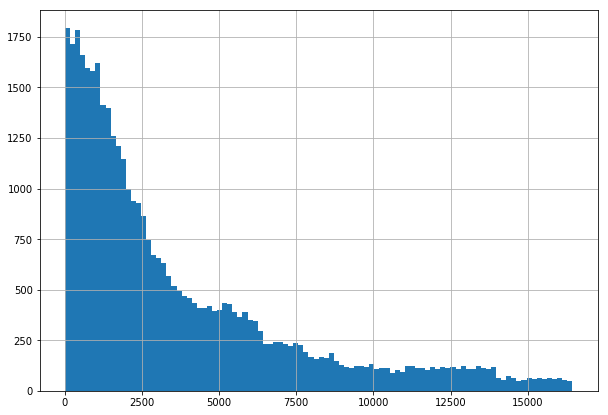

In [19]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

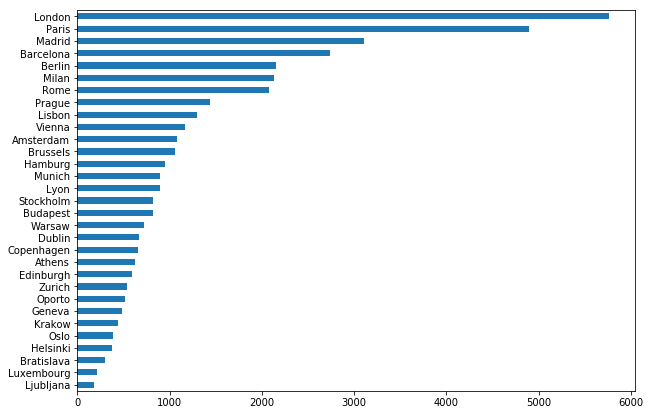

In [20]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

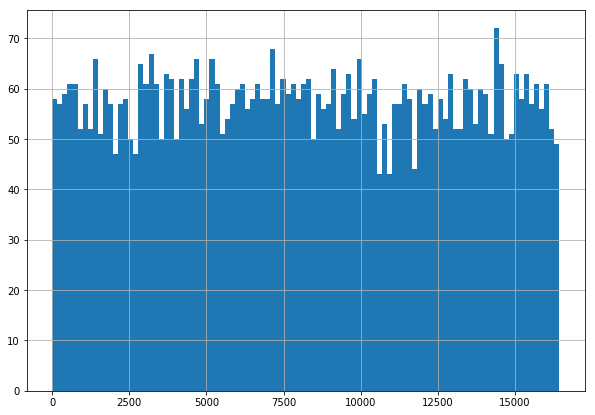

In [21]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

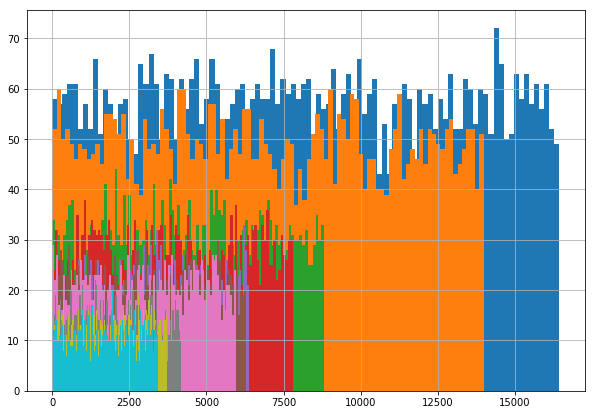

In [22]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение

### Посмотрим распределение целевой переменной

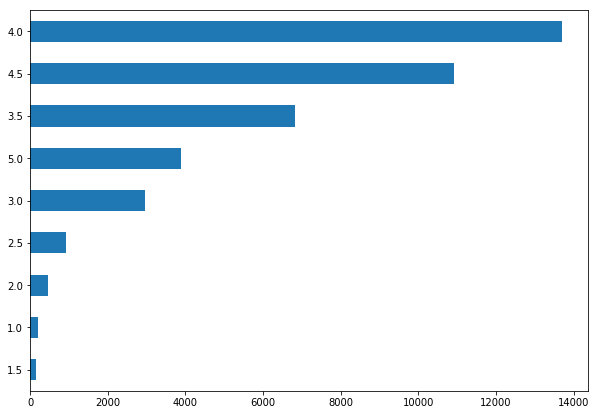

In [23]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

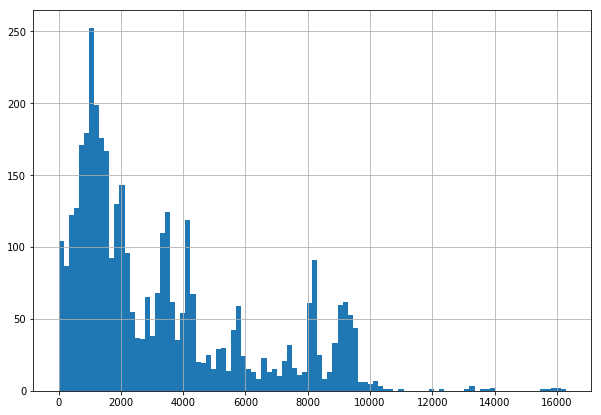

In [24]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

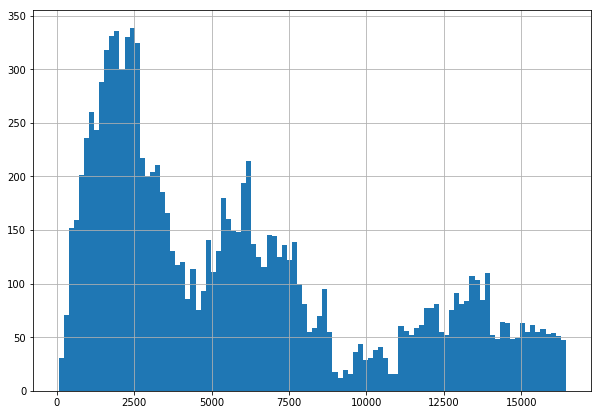

In [25]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [26]:
# применим нормализацию и создадим новый признак
data['Ranking_norm'] = data['Ranking']/data.City.map(dict(data['City'].value_counts()))

### 4 Rating — рейтинг ресторана по данным TripAdvisor 

In [27]:
data.loc[:, ['Rating']].info()
display(pd.DataFrame(data.Rating.value_counts()))
data.Rating.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Rating    50000 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


,Rating
4.0,13692
4.5,10929
0.0,10000
3.5,6824
5.0,3879
3.0,2955
2.5,915
2.0,466
1.0,201
1.5,139


count    50000.000000
mean         3.194430
std          1.705453
min          0.000000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

##### пропусков нет, числовой признак,именно это значение должна будет предсказывать модель, возможные значения от 1 до 5, шаг 0,5

### Price_Range — диапазон цен в ресторане

In [28]:
data.loc[:, ['Price_Range']].info()
print (pd.DataFrame(data.Price_Range.value_counts())) #display отображает не информативно
data.Price_Range.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Price_Range    32639 non-null object
dtypes: object(1)
memory usage: 390.8+ KB
          Price_Range
$$ - $$$        23041
$                7816
$$$$             1782


count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price_Range, dtype: object

##### есть пропуски, ординальный признак, необходима обработка

In [29]:
# заполним пропущенные значения наиболее часто встречающимся
data['Price_Range'] = data['Price_Range'].fillna('$$ - $$$')
# Создадим словарь для преобразования значений уровня цен
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
# выполним преобразование
data['Price_Range'].replace(price_dict, inplace=True)

###  Number_of_Reviews — количество отзывов о ресторане

In [30]:
# заполним пропуски средним, данную операцию вынесем в предобработку столбца 
data['Number_of_Reviews'].isna().value_counts()
data['Number_of_Reviews'].fillna(125, inplace=True)

In [31]:
data.loc[:, ['Number_of_Reviews']].info()
display(pd.DataFrame(data.Number_of_Reviews.value_counts()))
data.Number_of_Reviews.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Number_of_Reviews    50000 non-null float64
dtypes: float64(1)
memory usage: 390.8 KB


,Number_of_Reviews
125.0,3257
2.0,2403
3.0,2042
4.0,1707
5.0,1471
...,...
5216.0,1
1932.0,1
1050.0,1
1145.0,1


count    50000.000000
mean       124.505040
std        284.546914
min          2.000000
25%         10.000000
50%         38.000000
75%        125.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64

### 7 Reviews — данные о двух отзывах, которые отображаются на сайте ресторана

In [32]:
data.loc[:, ['Reviews']].info()
display(pd.DataFrame(data.Reviews.value_counts()))
data.Reviews.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Reviews    49998 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


,Reviews
"[[], []]",8112
"[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]",2
"[['Delicious soup', 'My weekly treat'], ['03/19/2017', '07/30/2017']]",2
"[['ok for beer, not for dinner'], ['12/20/2017']]",2
"[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]",2
...,...
"[['Great view', 'Terrible meal'], ['11/15/2015', '09/13/2015']]",1
"[['Excellent', 'Lovely cake shop'], ['11/12/2017', '07/10/2017']]",1
"[['Very good food', 'Avoid!!!'], ['01/06/2018', '12/22/2017']]",1
"[['The food delicious and generous'], ['07/09/2015']]",1


count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object

##### есть пропуски, категориальный признак, есть повторояющиеся отзывы, возможно использование для дальнейшего улучшения модели

### URL_TA — URL страницы ресторана на TripAdvisor

In [33]:
data.loc[:, ['URL_TA']].info()
display(pd.DataFrame(data.URL_TA.value_counts()))
data.URL_TA.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
URL_TA    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


,URL_TA
/Restaurant_Review-g187514-d1235635-Reviews-Restaurante_Arroceria_Puerta_de_Atocha-Madrid.html,2
/Restaurant_Review-g187514-d7809594-Reviews-La_Guapa-Madrid.html,2
/Restaurant_Review-g187514-d1028622-Reviews-La_Terraza_del_Urban-Madrid.html,2
/Restaurant_Review-g187514-d7827387-Reviews-El_Gusto_Es_Nuestro-Madrid.html,2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html,2
...,...
/Restaurant_Review-g190454-d8334746-Reviews-La_Mia-Vienna.html,1
/Restaurant_Review-g186338-d12828887-Reviews-Zad_Restaurant-London_England.html,1
/Restaurant_Review-g187147-d2037763-Reviews-Au_Grat_In-Paris_Ile_de_France.html,1
/Restaurant_Review-g186338-d734276-Reviews-Hana-London_England.html,1


count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d1235635-Reviews-Re...
freq                                                      2
Name: URL_TA, dtype: object

##### нет пропусков, категориальный признак, есть повторяющиеся значения, непонятно влияние этого параметра на рейтинг, в текущий момент не используем

### ID_TA — идентификатор ресторана в базе данных TripAdvisor

In [34]:
data.loc[:, ['ID_TA']].info()
display(pd.DataFrame(data.ID_TA.value_counts()))
data.ID_TA.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
ID_TA    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


,ID_TA
d4600226,2
d3685055,2
d793170,2
d10047799,2
d2360290,2
...,...
d1034586,1
d5267617,1
d12657457,1
d12331579,1


count        50000
unique       49963
top       d4600226
freq             2
Name: ID_TA, dtype: object

##### нет пропусков, категориальный признак, есть повторяющиеся значения, непонятно влияние этого параметра на рейтинг, в текущий момент не используем

### Корреляция признаков
посмотрим, как признаки связаны между собой и с целевой переменной.

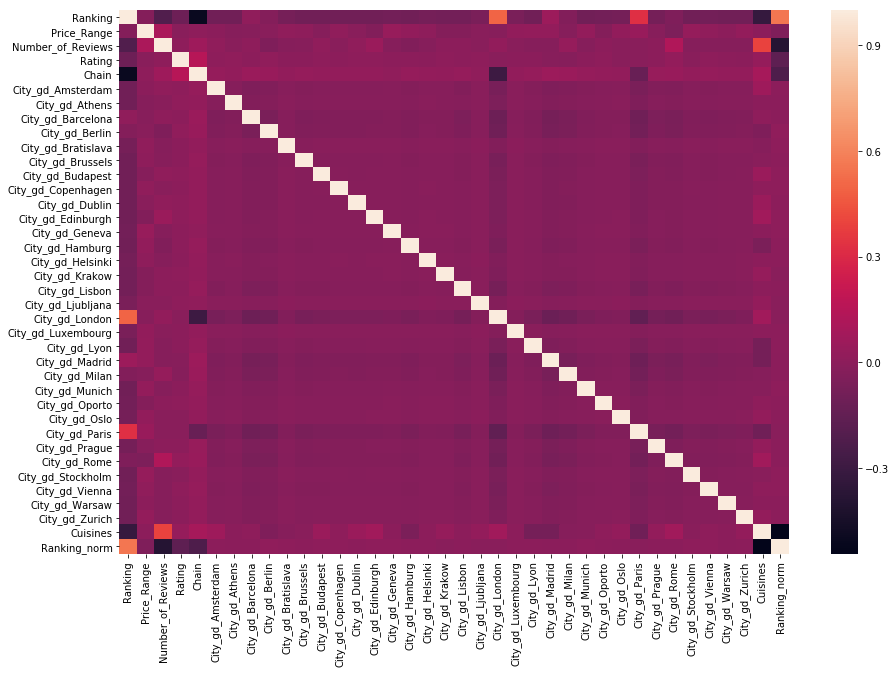

In [35]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

сильная положительная корреляция между кол-вом кухонь в ресторане и рейтингом внутри одного города

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [36]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [37]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [38]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
31825,1381.0,322.0,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44609,4744.0,92.0,1,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16650,3350.0,22.0,1,4.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3076,13888.0,5.0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18927,7595.0,25.0,1,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39307,5342.0,3.0,1,4.5,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2161,1666.0,130.0,0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47060,3916.0,120.0,1,4.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12798,106.0,361.0,1,4.5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30178,6743.0,7.0,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
Ranking              50000 non-null float64
Number of Reviews    50000 non-null float64
sample               50000 non-null int64
Rating               50000 non-null float64
City_Amsterdam       50000 non-null uint8
City_Athens          50000 non-null uint8
City_Barcelona       50000 non-null uint8
City_Berlin          50000 non-null uint8
City_Bratislava      50000 non-null uint8
City_Brussels        50000 non-null uint8
City_Budapest        50000 non-null uint8
City_Copenhagen      50000 non-null uint8
City_Dublin          50000 non-null uint8
City_Edinburgh       50000 non-null uint8
City_Geneva          50000 non-null uint8
City_Hamburg         50000 non-null uint8
City_Helsinki        50000 non-null uint8
City_Krakow          50000 non-null uint8
City_Lisbon          50000 non-null uint8
City_Ljubljana       50000 non-null uint8
City_London          50000 non-null uint8
Cit

In [40]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [41]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 35), (40000, 35), (40000, 34), (32000, 34), (8000, 34))

# Model 
Сам ML

In [43]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [44]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [46]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21240125


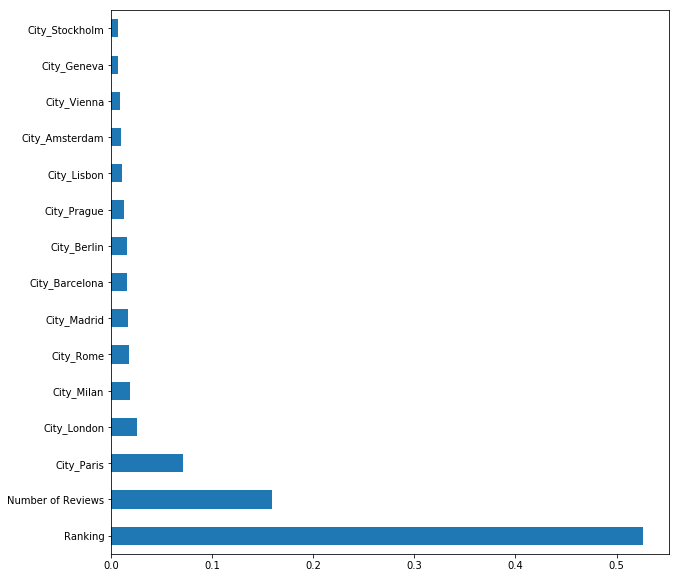

In [47]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [48]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
2230,12363.0,2.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7502,5177.0,0.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4166,106.0,4608.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1691,1398.0,10.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4644,2553.0,145.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8242,1018.0,217.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4285,2137.0,8.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2903,3542.0,55.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7576,7963.0,3.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6042,617.0,15.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
test_data = test_data.drop(['Rating'], axis=1)

In [50]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [51]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [52]:
predict_submission

array([3.005, 4.295, 4.56 , ..., 3.   , 4.5  , 4.32 ])

In [53]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.295
2,id_2,4.560
3,id_3,4.155
4,id_4,4.485
5,id_5,4.580
6,id_6,1.475
7,id_7,3.220
8,id_8,4.100
9,id_9,4.750


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
